# introduction

Objectif : Prédire par Réseaux de neurones une catégorie

Les prescriptions de médicaments comportent parfois des erreurs ou des risques potentiels qui nécessitent une intervention pharmaceutique (IP). Ce projet a pour objectif de développer deux modèles de classification pour prédire la nécessité et la nature de ces IPs, en se basant sur les commentaires de pharmaciens, selon les critères établis par la Société Française de Pharmacie Clinique. Le premier modèle est conçu pour prédire si une IP est classée comme « grave » ou « non-grave ». Le deuxième modèle vise à identifier la classe spécifique de l'IP parmi 11 catégories.

Les données utilisées proviennent des Hôpitaux Universitaires de Strasbourg. Après un prétraitement initial pour supprimer les lignes vides, deux colonnes cibles ont été créées à partir de la colonne 'PLT' : la première (IP_1) codifie la gravité de l'IP (1 pour « grave », 0 pour « non-grave »), tandis que la seconde (IP_2) correspond à la classe d'IP (de 1 à 11).

Ce travail met en lumière un outil potentiel pour assister les pharmaciens dans l'évaluation des IPs, en intégrant des modèles de classification avancés pour une prise de décision éclairée et sécurisée.

# import library

In [1]:
import pandas as pd
import numpy as np

# DataManagement
import re
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Split train/test
from sklearn.model_selection import train_test_split

# Vectorisation
from sklearn.feature_extraction.text import TfidfVectorizer

# SMOTE
from imblearn.over_sampling import SMOTE

# Class_Weight
from sklearn.utils.class_weight import compute_class_weight

# Modèle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, GlobalAveragePooling1D, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

# Evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

# import files

In [2]:
!gdown 1foGLOCbc_OS_ODX3c2At0SiiZCt23vaV -O data_defi_2.csv

Downloading...
From: https://drive.google.com/uc?id=1foGLOCbc_OS_ODX3c2At0SiiZCt23vaV
To: /content/data_defi_2.csv
100% 3.08M/3.08M [00:00<00:00, 44.5MB/s]


In [3]:
!gdown 1Mvx8EIZsgbPtbc2xukulgXT4_HArYbmV -O valid_set.csv

Downloading...
From: https://drive.google.com/uc?id=1Mvx8EIZsgbPtbc2xukulgXT4_HArYbmV
To: /content/valid_set.csv
100% 556k/556k [00:00<00:00, 24.6MB/s]


In [4]:
data_defi_2 = pd.read_csv("data_defi_2.csv", sep =";", encoding='latin-1')
valid_set = pd.read_csv("valid_set.csv", sep =";")
display(data_defi_2.head())
display(valid_set.head())

,Column1,Column2,Column3
0,Libellé.Prescription,Avis.Pharmaceutique,PLT
1,"CONTRAMAL 100 MG/ML, GOUTTES BUV (TRAMADOL)",30/12/16 pas d'indication,5.3
2,"IMOVANE 7.5 MG, CPR SÉCABLE (ZOPICLONE)","22/12/16 recommandé -> IMOVANE 3,75MG CP, 1 au...",4.1
3,"COLCHICINE 1 MG, CPR SÉCABLE (COLCHICINE)","au vue de la DFG, il est recommandé d'administ...",4.1
4,"PANTOPRAZOLE 40 MG, CPR GASTRO-RÉSISTANT (EUPA...",Dose curative et absence d'ATCD gastrique retr...,4.1


,Libellé.Prescription,Avis.Pharmaceutique
0,perf NEFOPAM 60 mg (Acupan) + 1.25 DROPERIDOL ...,ASSOCIATION CONTRE INDIQUEE : SEROPLEX 20 MG C...
1,"LAMALINE, GÉLULE",Propose arrêt pendant hospitalisation ou DOLIP...
2,"XYZALL 5 MG, CPR","Non référencé aux HUS, propose CETIRIZINE 10MG..."
3,AMOXICILLINE + A.CLAVULANIQUE 1g x4/j (Augmentin),Il est recommandé de réduire la posologie en a...
4,"FELODIPINE LP 5 MG SANDOZ, CPR À LIBÉRATION PR...","Non référencé aux HUS, Substitué par amlodipin..."


# DataManagement

In [5]:
#df["Column3"].value_counts()
#df.isnull().sum()
#df.info()

In [ ]:
df = data_defi_2.copy()
df.columns = df.iloc[0]
df = df.iloc[1:].reset_index(drop=True)
df = df.dropna(subset=['Avis.Pharmaceutique'])
df["text"] = df["Libellé.Prescription"] + " " + df["Avis.Pharmaceutique"]
def clean_text(t):
    t = t.lower()
    t = re.sub(r'[^a-zA-Zà-ÿ0-9\s]', '', t)
    return t
df["text"] = df["text"].apply(clean_text)
df['PLT'] = pd.to_numeric(df['PLT'], errors='coerce')
df['IP_1'] = np.where(df['PLT'].isin([4.1, 4.2, 5.1, 5.2, 5.3, 6.3, 6.4]), 1, 0)
df['IP_2'] = np.floor(df['PLT']).astype(int)
df = df.drop_duplicates().reset_index(drop=True)
df.head()

# IP_1

## Split train/test

In [7]:
X = df['text'].values
y = df['IP_1'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## vectorisation

In [8]:
vectorizer = TfidfVectorizer(max_features=10000)  # limite vocabulaire
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Conversion en dense
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

## SMOTE

In [9]:
# SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_dense, y_train)

print(f"Avant SMOTE : {sum(y_train==1)}/{len(y_train)} positifs")
print(f"Après SMOTE  : {sum(y_train_res==1)}/{len(y_train_res)} positifs")

Avant SMOTE : 3622/18512 positifs
Après SMOTE  : 14890/29780 positifs


## Modèle

In [10]:
model_IP_1 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # sortie binaire
])

model_IP_1.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
history = model_IP_1.fit(
    X_train_res, y_train_res,
    validation_split=0.1,
    epochs=5,
    batch_size=32
)

Epoch 1/5
838/838 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8559 - loss: 0.3195 - val_accuracy: 0.9691 - val_loss: 0.1020
Epoch 2/5
838/838 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - accuracy: 0.9705 - loss: 0.0851 - val_accuracy: 0.9923 - val_loss: 0.0356
Epoch 3/5
838/838 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.9860 - loss: 0.0447 - val_accuracy: 0.9946 - val_loss: 0.0213
Epoch 4/5
838/838 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - accuracy: 0.9905 - loss: 0.0290 - val_accuracy: 0.9980 - val_loss: 0.0107
Epoch 5/5
838/838 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.9928 - loss: 0.0232 - val_accuracy: 0.9983 - val_loss: 0.0128


## evaluation

In [12]:
y_pred_proba = model_IP_1.predict(X_test_dense)
y_pred = (y_pred_proba > 0.5).astype(int) # Convert probabilities to binary predictions

print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision : {precision_score(y_test, y_pred):.3f}")
print(f"Recall : {recall_score(y_test, y_pred):.3f}")
print(f"F1 score : {f1_score(y_test, y_pred):.3f}")
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))
print("Classification report :")
print(classification_report(y_test, y_pred))

145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Accuracy : 0.919
Precision : 0.829
Recall : 0.741
F1 score : 0.783
Matrice de confusion :
[[3585  138]
 [ 235  671]]
Classification report :
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3723
           1       0.83      0.74      0.78       906

    accuracy                           0.92      4629
   macro avg       0.88      0.85      0.87      4629
weighted avg       0.92      0.92      0.92      4629



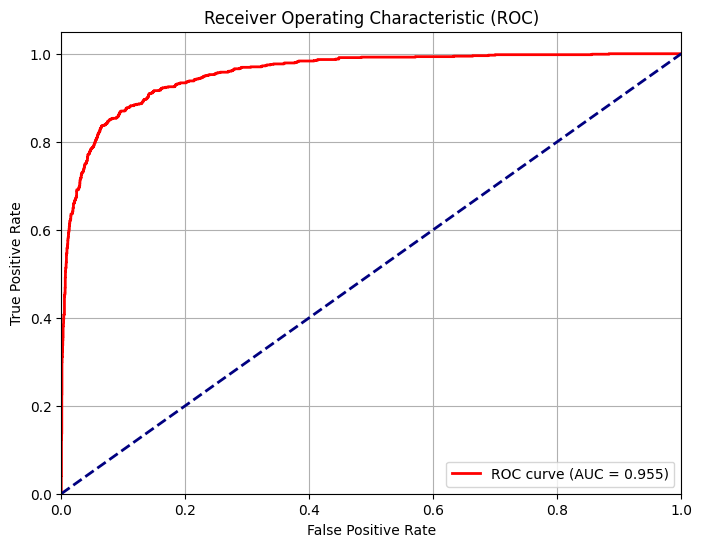

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # ligne diagonale
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# IP_2

## Split train/test

In [14]:
X = df['text'].values
y = df['IP_2'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Vectorisation

In [15]:
vectorizer = TfidfVectorizer(max_features=10000)  # limite vocabulaire
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Conversion en dense
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

## Class_Weight

In [16]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

## Modèle

In [17]:
num_classes = 12

model_IP_2 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # sortie multiclasse
])


model_IP_2.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
history = model_IP_2.fit(
    X_train_dense, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=32,
    class_weight=class_weights
)

Epoch 1/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.3169 - loss: 24.2434 - val_accuracy: 0.5497 - val_loss: 1.6852
Epoch 2/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.6224 - loss: 3.8663 - val_accuracy: 0.6523 - val_loss: 1.3804
Epoch 3/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.7212 - loss: 2.3295 - val_accuracy: 0.6771 - val_loss: 1.2115
Epoch 4/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.7753 - loss: 1.8949 - val_accuracy: 0.6982 - val_loss: 1.1807
Epoch 5/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.8210 - loss: 1.5150 - val_accuracy: 0.7230 - val_loss: 1.1472


## evaluation

In [19]:
y_pred_proba = model_IP_2.predict(X_test_dense)
y_pred = y_pred_proba.argmax(axis=1)

print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision : {precision_score(y_test, y_pred, average='macro'):.3f}")
print(f"Recall : {recall_score(y_test, y_pred, average='macro'):.3f}")
print(f"F1 score : {f1_score(y_test, y_pred, average='macro'):.3f}")
print("Classification report :")
print(classification_report(y_test, y_pred))

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy : 0.741
Precision : 0.534
Recall : 0.463
F1 score : 0.461
Classification report :
              precision    recall  f1-score   support

           1       0.84      0.89      0.87      2253
           2       0.79      0.66      0.72       151
           3       0.40      0.01      0.02       194
           4       0.72      0.75      0.73       613
           5       0.66      0.43      0.52       166
           6       0.67      0.87      0.76       193
           7       0.00      0.00      0.00         2
           8       0.54      0.87      0.67       589
           9       0.00      0.00      0.00         4
          10       0.65      0.47      0.55       148
          11       0.60      0.16      0.25       316

    accuracy                           0.74      4629
   macro avg       0.53      0.46      0.46      4629
weighted avg       0.73      0.74      0.71      4629



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

# Test

In [20]:
df_test = valid_set.copy()
df_test = df_test.dropna(subset=['Avis.Pharmaceutique'])
df_test["text"] = df_test["Libellé.Prescription"] + df_test["Avis.Pharmaceutique"]
def clean_text(t):
    t = t.lower()
    t = re.sub(r'[^a-zA-Zà-ÿ0-9\s]', '', t)
    return t
df_test["text"] = df_test["text"].apply(clean_text)
df_test.head()

,Libellé.Prescription,Avis.Pharmaceutique,text
0,perf NEFOPAM 60 mg (Acupan) + 1.25 DROPERIDOL ...,ASSOCIATION CONTRE INDIQUEE : SEROPLEX 20 MG C...,perf nefopam 60 mg acupan 125 droperidol drol...
1,"LAMALINE, GÉLULE",Propose arrêt pendant hospitalisation ou DOLIP...,lamaline gélulepropose arrêt pendant hospitali...
2,"XYZALL 5 MG, CPR","Non référencé aux HUS, propose CETIRIZINE 10MG...",xyzall 5 mg cprnon référencé aux hus propose c...
3,AMOXICILLINE + A.CLAVULANIQUE 1g x4/j (Augmentin),Il est recommandé de réduire la posologie en a...,amoxicilline aclavulanique 1g x4j augmentinil...
4,"FELODIPINE LP 5 MG SANDOZ, CPR À LIBÉRATION PR...","Non référencé aux HUS, Substitué par amlodipin...",felodipine lp 5 mg sandoz cpr à libération pro...


In [21]:
X_test_final = vectorizer.transform(df_test["text"]).toarray()

pred_ip1 = model_IP_1.predict(X_test_final)
pred_ip1 = (pred_ip1 > 0.5).astype("int32").flatten()

pred_ip2_proba = model_IP_2.predict(X_test_final)
pred_ip2 = pred_ip2_proba.argmax(axis=1)

result = pd.DataFrame({
    'Prescription': df_test['Libellé.Prescription'],
    'IP_1': pred_ip1,
    'IP_2': pred_ip2
})

result.head()

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


,Prescription,IP_1,IP_2
0,perf NEFOPAM 60 mg (Acupan) + 1.25 DROPERIDOL ...,1,6
1,"LAMALINE, GÉLULE",0,8
2,"XYZALL 5 MG, CPR",0,1
3,AMOXICILLINE + A.CLAVULANIQUE 1g x4/j (Augmentin),0,4
4,"FELODIPINE LP 5 MG SANDOZ, CPR À LIBÉRATION PR...",0,1


In [22]:
display(result.groupby('IP_1').size())
display(result.groupby('IP_2').size())

,0
IP_1,
0,3767
1,307


,0
IP_2,
1,1976
2,100
4,543
5,78
6,268
8,978
10,79
11,52


In [24]:
result.to_csv('result.csv', index=False)